In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import warnings
warnings.filterwarnings('ignore')
import numpy as np


In [2]:
df = pd.read_csv('../cleaned_cpo_price.csv', index_col="Date").dropna()
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


Text(0.5, 0, 'Date')

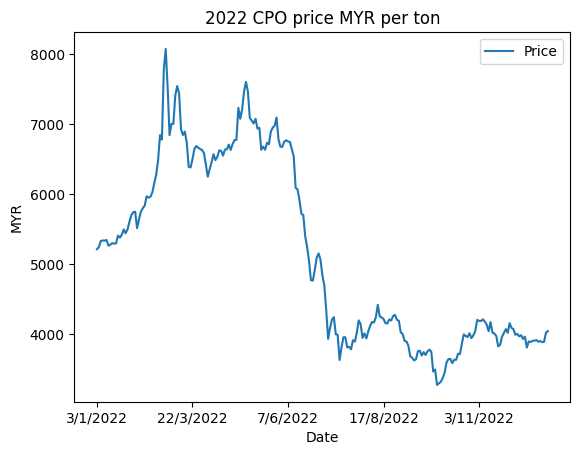

In [3]:
df.plot()
plt.title("2022 CPO price MYR per ton")
plt.ylabel("MYR")
plt.xlabel("Date")

In [4]:
pct_change = 100 * df.pct_change().dropna()
pct_change

,Price
Date,
4/1/2022,0.604143
5/1/2022,1.629969
6/1/2022,0.168824
7/1/2022,-0.074906
10/1/2022,0.206147
...,...
21/12/2022,0.218341
22/12/2022,-0.384468
23/12/2022,0.102920


Text(0.5, 1.0, 'Volatility of the series')

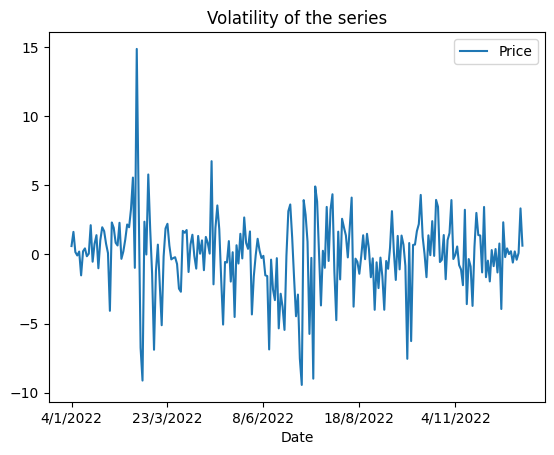

In [16]:
pct_change.plot()
plt.title('Volatility of the series')

In [6]:
dt_srs = list(pct_change.Price)

Text(0.5, 1.0, 'Autocorrelation Original Series')

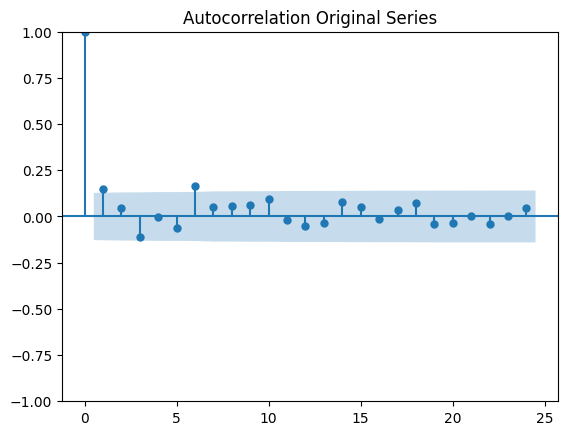

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(pct_change)
plt.title("Autocorrelation Original Series")

In [20]:
# split into train/test
from arch import arch_model
n_test = 12
train, test = dt_srs[:-n_test], dt_srs[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='ARCH', p=1)

# fit model
model_fit = model.fit()

# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
yhat

Iteration:      1,   Func. Count:      4,   Neg. LLF: 552.134645727739
Iteration:      2,   Func. Count:      9,   Neg. LLF: 549.5268262163443
Iteration:      3,   Func. Count:     12,   Neg. LLF: 549.5268147864047
Iteration:      4,   Func. Count:     14,   Neg. LLF: 549.5268147864496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 549.5268147864047
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4


In [21]:
model_fit.summary

<bound method ARCHModelResult.summary of                         Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -549.527
Distribution:                  Normal   AIC:                           1103.05
Method:            Maximum Likelihood   BIC:                           1109.88
                                        No. Observations:                  224
Date:                Wed, Jul 12 2023   Df Residuals:                      224
Time:                        12:27:26   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          7.248

In [9]:
np.sqrt(yhat.variance.values[-1, :])

array([2.70369832, 2.82370662, 2.83533098, 2.83648117, 2.83659521,
       2.83660652, 2.83660764, 2.83660775, 2.83660776, 2.83660776,
       2.83660776, 2.83660776])

<Axes: >

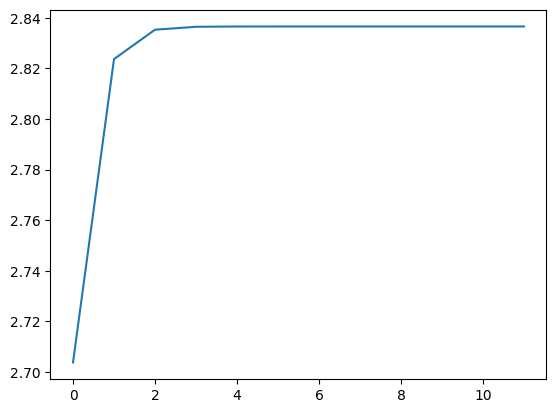

In [10]:
it = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
it.plot()

<Axes: >

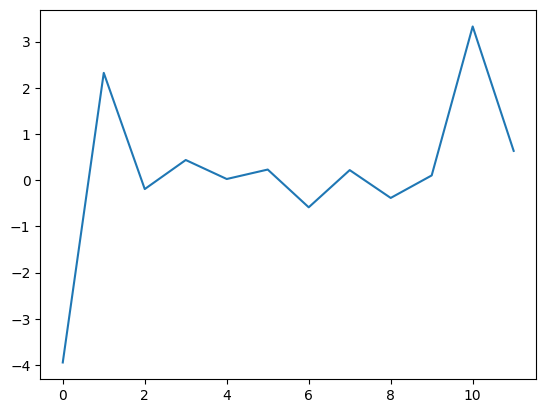

In [11]:
tt = pd.Series(test)
tt.plot()

<Axes: >

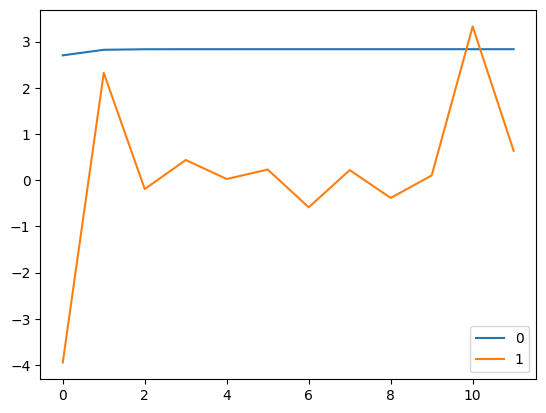

In [12]:
pd.concat([it,tt], axis= 1).plot()

### one step ahead forecast

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='ARCH', p=1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    err = np.sqrt(mean_squared_error(test_val, pred_)) #rmse
    return err
    
one_step_ahead(df, .8)

def loop_pct():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 476.6030436770907
Iteration:      2,   Func. Count:      9,   Neg. LLF: 474.6168616545666
Iteration:      3,   Func. Count:     12,   Neg. LLF: 474.61652830743304
Iteration:      4,   Func. Count:     14,   Neg. LLF: 474.6165283074481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.61652830743304
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: 476.6030436770907
Iteration:      2,   Func. Count:      9,   Neg. LLF: 474.6168616545666
Iteration:      3,   Func. Count:     12,   Neg. LLF: 474.61652830743304
Iteration:      4,   Func. Count:     14,   Neg. LLF: 474.6165283074481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.61652830743304
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Iterat

,pct,res
0,0.80,3.351253
1,0.85,3.509318
2,0.90,3.260974
3,0.95,2.558351


In [14]:
# MAPE

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def one_step_ahead_mape(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='ARCH', p=1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    err = mean_absolute_percentage_error(test_val, pred_) #mape
    return err
    
one_step_ahead_mape(df, .8)

def loop_pct_mape():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_mape(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_mape()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 476.6030436770907
Iteration:      2,   Func. Count:      9,   Neg. LLF: 474.6168616545666
Iteration:      3,   Func. Count:     12,   Neg. LLF: 474.61652830743304
Iteration:      4,   Func. Count:     14,   Neg. LLF: 474.6165283074481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.61652830743304
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: 476.6030436770907
Iteration:      2,   Func. Count:      9,   Neg. LLF: 474.6168616545666
Iteration:      3,   Func. Count:     12,   Neg. LLF: 474.61652830743304
Iteration:      4,   Func. Count:     14,   Neg. LLF: 474.6165283074481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.61652830743304
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Iterat

,pct,res
0,0.80,8.857323
1,0.85,8.216676
2,0.90,10.709065
3,0.95,18.142985


### Plotting

Iteration:      1,   Func. Count:      4,   Neg. LLF: 476.6030436770907
Iteration:      2,   Func. Count:      9,   Neg. LLF: 474.6168616545666
Iteration:      3,   Func. Count:     12,   Neg. LLF: 474.61652830743304
Iteration:      4,   Func. Count:     14,   Neg. LLF: 474.6165283074481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.61652830743304
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4


<Axes: >

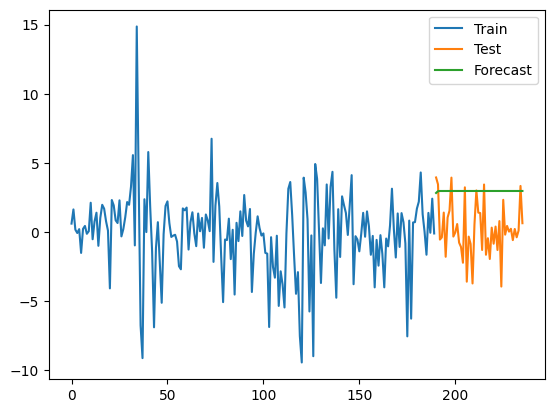

In [15]:
def plot_arch(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='ARCH', p=1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    err = mean_absolute_percentage_error(test_val, pred_) #mape
    df_t = pd.DataFrame(train_)
    df_te = pd.DataFrame(test_)
    df_p = pd.DataFrame(pred_)
    df_res = pd.concat([df_te, df_p], axis= 1)
    df_res['index'] = range(190, 236)
    df_res.set_index(['index'], inplace=True)
    df_res = pd.concat([df_t, df_res], axis= 1)
    df_res.columns = ['Train', 'Test', 'Forecast']
    return df_res.plot()
    
plot_arch(df, .8)